In [4]:
from pysolar.solar import get_altitude, get_azimuth
from datetime import datetime, timedelta
from pytz import timezone
import numpy as np

def calculate_solar_positions(
    start_date: datetime,
    start_hour: int = 10,
    end_hour: int = 17,
    latitude: float = -0.2105367,
    longitude: float = -78.491614
):
    """Calcula posiciones solares y ángulos para una fecha específica y rango de horas.

    ## Parameters
    - start_date: Fecha y hora de inicio para la simulación (se usa solo la fecha, hora se define con start_hour).
    - start_hour: Hora de inicio del cálculo.
    - end_hour: Hora de fin del cálculo.
    - latitude: Latitud para la posición geográfica.
    - longitude: Longitud para la posición geográfica.

    ## Return
    - times: Lista de tiempos de simulación.
    - azimuths: Lista de ángulos azimutales.
    - elevations: Lista de ángulos de elevación.
    - beta: Lista de ángulos de rollo calculados.
    - phi: Lista de ángulos de inclinación calculados.
    """
    times = []
    azimuths = []
    elevations = []
    beta = []
    phi = []

    time_interval = timedelta(hours=1)

    # Crear el rango de tiempos basado en la hora de inicio y fin
    start_time = start_date.replace(hour=start_hour, minute=0, second=0, microsecond=0)
    end_time = start_date.replace(hour=end_hour, minute=0, second=0, microsecond=0)

    current_time = start_time
    while current_time <= end_time:
        az = get_azimuth(latitude, longitude, current_time)
        el = get_altitude(latitude, longitude, current_time)

        # Convertir a radianes para los cálculos
        az_rad = (az * np.pi) / 180
        el_rad = (el * np.pi) / 180

        val = np.cos(el_rad) * np.sin(az_rad)
        beta_rad = np.arcsin(val)
        beta_deg = (beta_rad * 180) / np.pi

        val_fi1 = -(np.cos(el_rad) * np.cos(az_rad)) / np.cos(beta_rad)
        x_rad = np.arcsin(val_fi1)
        x_deg = (x_rad * 180) / np.pi

        val_fi2 = np.sin(el_rad) / np.cos(beta_rad)
        y_rad = np.arccos(val_fi2)
        y_deg = (y_rad * 180) / np.pi

        times.append(current_time)
        azimuths.append(az)
        elevations.append(el)
        beta.append(beta_deg)
        phi.append(x_deg)  # Asumiendo que phi corresponde a x_deg; ajusta si es necesario

        current_time += time_interval

    return times, azimuths, elevations, beta, phi

Ingrese una fecha en formato año-mes-día (ejemplo: 2024-08-11):  2022-10-03
Ingrese el rango de la simulación (ejemplo: 10-17):  6-18


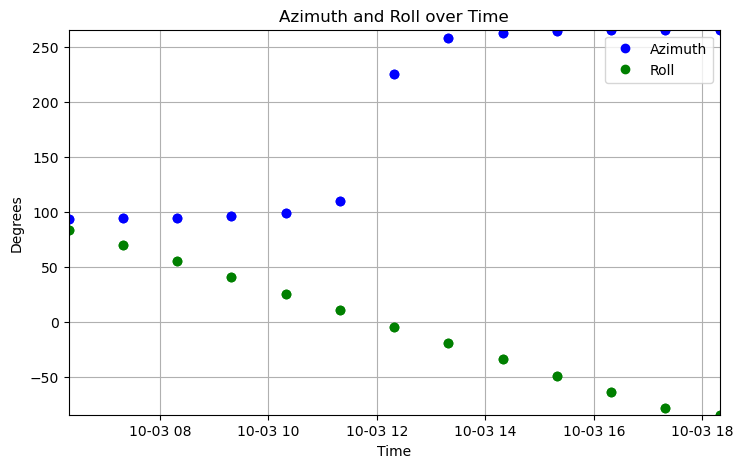

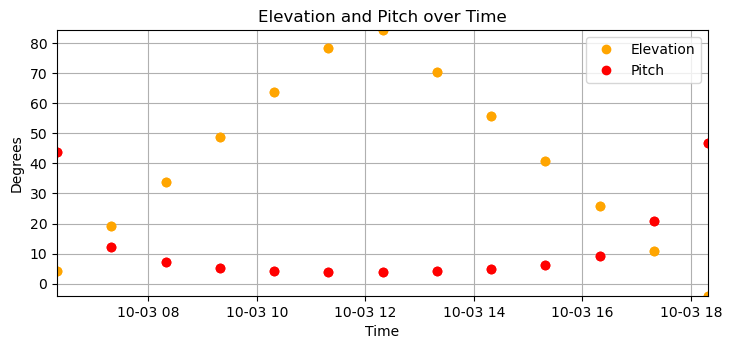

In [6]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
import numpy as np

# Extraer los datos de tiempo, azimuth y elevación
#times = [pos[0] for pos in solar_positions]
#azimuths = [pos[1] for pos in solar_positions]
#elevations = [pos[2] for pos in solar_positions]
#beta = [sol[0] for sol in solucion]
#phi = [sol[1] for sol in solucion]

fecha = input("Ingrese una fecha en formato año-mes-día (ejemplo: 2024-08-11): ")
anio, mes, dia = fecha.split('-')
rango = input("Ingrese el rango de la simulación (ejemplo: 10-17): ")
inicio, fin = rango.split('-')

start_date = datetime(int(anio), int(mes), int(dia), tzinfo=timezone("America/Guayaquil"))
times, azimuths, elevations, beta, phi = calculate_solar_positions(start_date, start_hour=int(inicio), end_hour=int(fin))

# Configurar la ventana de Tkinter
root = tk.Tk()
root.title("Simulación de Ángulos Solares")

# Crear un marco para la gráfica 3D
frame_3d = tk.Frame(root)
frame_3d.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

# Crear un marco para las gráficas 2D
frame_2d = tk.Frame(root)
frame_2d.pack(side=tk.BOTTOM, fill=tk.BOTH, expand=True)

# Crear la figura para la gráfica de Azimuth y Roll
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_xlabel('Time')
ax1.set_ylabel('Degrees')
ax1.set_title('Azimuth and Roll over Time')
ax1.set_xlim(min(times), max(times))
ax1.set_ylim(min(min(azimuths), min(beta)), max(max(azimuths), max(beta)))
line1, = ax1.plot([], [], 'o', label='Azimuth', color='blue')
line2, = ax1.plot([], [], 'o', label='Roll', color='green')
ax1.legend()
ax1.grid(True)

# Crear la figura para la gráfica de Elevation y Pitch
fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.set_xlabel('Time')
ax2.set_ylabel('Degrees')
ax2.set_title('Elevation and Pitch over Time')
ax2.set_xlim(min(times), max(times))
ax2.set_ylim(min(min(elevations), min(phi)), max(max(elevations), max(phi)))
line3, = ax2.plot([], [], 'o', label='Elevation', color='orange')
line4, = ax2.plot([], [], 'o', label='Pitch', color='red')
ax2.legend()
ax2.grid(True)

# Agregar las figuras a la ventana de Tkinter
canvas1 = FigureCanvasTkAgg(fig1, master=frame_2d)
canvas1.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

canvas2 = FigureCanvasTkAgg(fig2, master=frame_2d)
canvas2.get_tk_widget().pack(side=tk.BOTTOM, fill=tk.BOTH, expand=1)

# Crear la figura y el eje 3D
fig3 = plt.Figure(figsize=(7, 7), dpi=100)
ax3 = fig3.add_subplot(111, projection='3d')

# Convertir los tiempos a números (por simplicidad en la gráfica 3D)
time_numbers = np.arange(len(times))

# Configurar los ejes
ax3.set_xlabel('Time')
ax3.set_ylabel('Azimuth / Roll (degrees)')
ax3.set_zlabel('Elevation / Pitch (degrees)')
ax3.set_title('Solar and Panel Trajectories')

# Inicializar las listas de puntos
points_solar, = ax3.plot([], [], [], 'bo', markersize=5)
points_panel, = ax3.plot([], [], [], 'r^', markersize=5)

# Función de inicialización para la animación 3D
def init_3d():
    ax3.set_xlim(min(time_numbers), max(time_numbers))
    ax3.set_ylim(min(min(azimuths), min(beta)), max(max(azimuths), max(beta)))
    ax3.set_zlim(min(min(elevations), min(phi)), max(max(elevations), max(phi)))
    return points_solar, points_panel

# Función de actualización para la animación 3D
def update_3d(frame):
    xdata = time_numbers[:frame+1]
    ydata_solar = azimuths[:frame+1]
    zdata_solar = elevations[:frame+1]
    ydata_panel = beta[:frame+1]
    zdata_panel = phi[:frame+1]
    points_solar.set_data(xdata, ydata_solar)
    points_solar.set_3d_properties(zdata_solar)
    points_panel.set_data(xdata, ydata_panel)
    points_panel.set_3d_properties(zdata_panel)
    return points_solar, points_panel

# Crear el lienzo para la figura 3D
canvas3 = FigureCanvasTkAgg(fig3, master=frame_3d)
canvas3.draw()
canvas3.get_tk_widget().pack(fill=tk.BOTH, expand=True)

# Función de inicialización para la animación 2D
def init_2d():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])
    return line1, line2, line3, line4

# Función de actualización para la animación 2D
def update_2d(frame):
    x_data1, y_data1 = line1.get_data()
    x_data2, y_data2 = line2.get_data()
    x_data3, y_data3 = line3.get_data()
    x_data4, y_data4 = line4.get_data()

    line1.set_data(np.append(x_data1, times[frame]), np.append(y_data1, azimuths[frame]))
    line2.set_data(np.append(x_data2, times[frame]), np.append(y_data2, beta[frame]))
    line3.set_data(np.append(x_data3, times[frame]), np.append(y_data3, elevations[frame]))
    line4.set_data(np.append(x_data4, times[frame]), np.append(y_data4, phi[frame]))

    return line1, line2, line3, line4

# Crear las animaciones
ani1 = animation.FuncAnimation(fig1, update_2d, frames=len(times), init_func=init_2d, interval=100)
ani2 = animation.FuncAnimation(fig2, update_2d, frames=len(times), init_func=init_2d, interval=100)
ani3 = animation.FuncAnimation(fig3, update_3d, frames=len(times), init_func=init_3d, interval=50, blit=True)

# Iniciar la interfaz gráfica de Tkinter
root.mainloop()
